# Sparkify Churn Prediction

In this notebook we'll analyze a small subset (128MB) of a fictitious dataset (12GB) containing records of users of a music streaming service called Sparkify. After properly defining churn, we will try to predict which customers are at risk of churn using different machine learning models. 

Let's load necessary libraries first.

In [1]:
# import libraries
import pyspark
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import udf, min, max, avg, sum as Fsum, concat, lit, count, when, isnan, col, isnull, to_date, from_unixtime, desc, asc, countDistinct, datediff, lag, round as Fround
from pyspark.sql.types import IntegerType, StringType, DateType, TimestampType, FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Churn Prediction") \
    .getOrCreate()

## Load and Clean Dataset

The file `mini_sparkify_event_data.json` contains the small subset of the dataset we will be working on. First, let's check for missing data, i.e. records without user ids or other values missing. 

In [3]:
# read in the data
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

Let's find out the data type of each variables in the dataset.

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



As a first step, let's check for empty values and nulls in the dataset.

In [5]:
# checking number of nulls and empties in the columns

empty = []
nans = []
nulls = []

for c in df.columns:
    empty.append(df.filter(col(c) == '').count())
    nans.append(df.filter(isnan(c)).count())
    nulls.append(df.filter(isnull(c)).count())
    

print('empty: {}\nnans: {}\nnulls: {}'.format(empty, nans, nulls))

empty: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8346]
nans: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
nulls: [58392, 0, 8346, 8346, 0, 8346, 58392, 0, 8346, 0, 0, 8346, 0, 58392, 0, 0, 8346, 0]


In the dataframe there are no nans, empty values are present only in the last column (`userId`), and there are some null values spread across. Let's see which columns have null values.

In [6]:
# check number of nulls for each column name
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



At first, the number of nulls (58392) seems related to the fact that some records have no song name, therefore also `artist` and `length` are null. Let's check if this assumption is true.

In [7]:
# check if nulls for the different columns are related to the same records:
df.filter(isnull(df.artist) & isnull(df.length) & isnull(df.song)).count()

58392

The other columns with null values have 8346 null records. These missing values seem related to those rows with no `userId`. Let's check this assumption.

In [8]:
# check if nulls due to missing userId are related to the same records:
df.filter(isnull(df.firstName) & isnull(df.gender) & isnull(df.lastName) & isnull(df.location) & isnull(df.registration)
         & isnull(df.userAgent)).count()

8346

From the results of the two cells above, we can see that the two assumptions made are correct, therefore there are null values in those records where there's no indication about users or where there's no song played.

Let's check now what happens when there's no user information.

In [9]:
# check the status of those rows with no userId
df.filter(col("userId")=="").groupby("auth").agg(count("userId")).show()

+----------+-------------+
|      auth|count(userId)|
+----------+-------------+
|Logged Out|         8249|
|     Guest|           97|
+----------+-------------+



The records with no `userId` are those when no user is logged in or when the user still hasn't subscribed to the service. Let's check the actions taken for these records.

In [10]:
# check actions performed when no user is logged in
df.select("page").filter(df.userId=='').dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



Since we can't really use the information available in those rows with no `userId` to predict customer churn (it's impossible to relate to who took a certain action), let's filter out those rows.

In [11]:
df = df.filter(df.userId != "")

## Exploratory Data Analysis

Now that the records with no user have been filtered out, let's get the total number of unique users and the amount of nulls in the columns that showed null values. These should be equal to the number of nulls due to those records with no songs (58392) minus the number of records with no user (8346), thus 50046. 

In [12]:
# total number of unique users
df.select("userid").distinct().count()

225

In [13]:
# check now the amount of nulls
print(df.filter(isnull(df.firstName) & isnull(df.gender) & isnull(df.lastName) & isnull(df.location) & isnull(df.registration)
         & isnull(df.userAgent)).count(),
df.filter(isnull(df.artist) & isnull(df.length) & isnull(df.song)).count())

0 50046


The cells above return the expected numbers. The amount of nulls is now related only to those records with no songs played. Let's plot the distribution of actions performed by users when they are not playing songs, i.e. when `page` column does not show *NextSong* as its value.

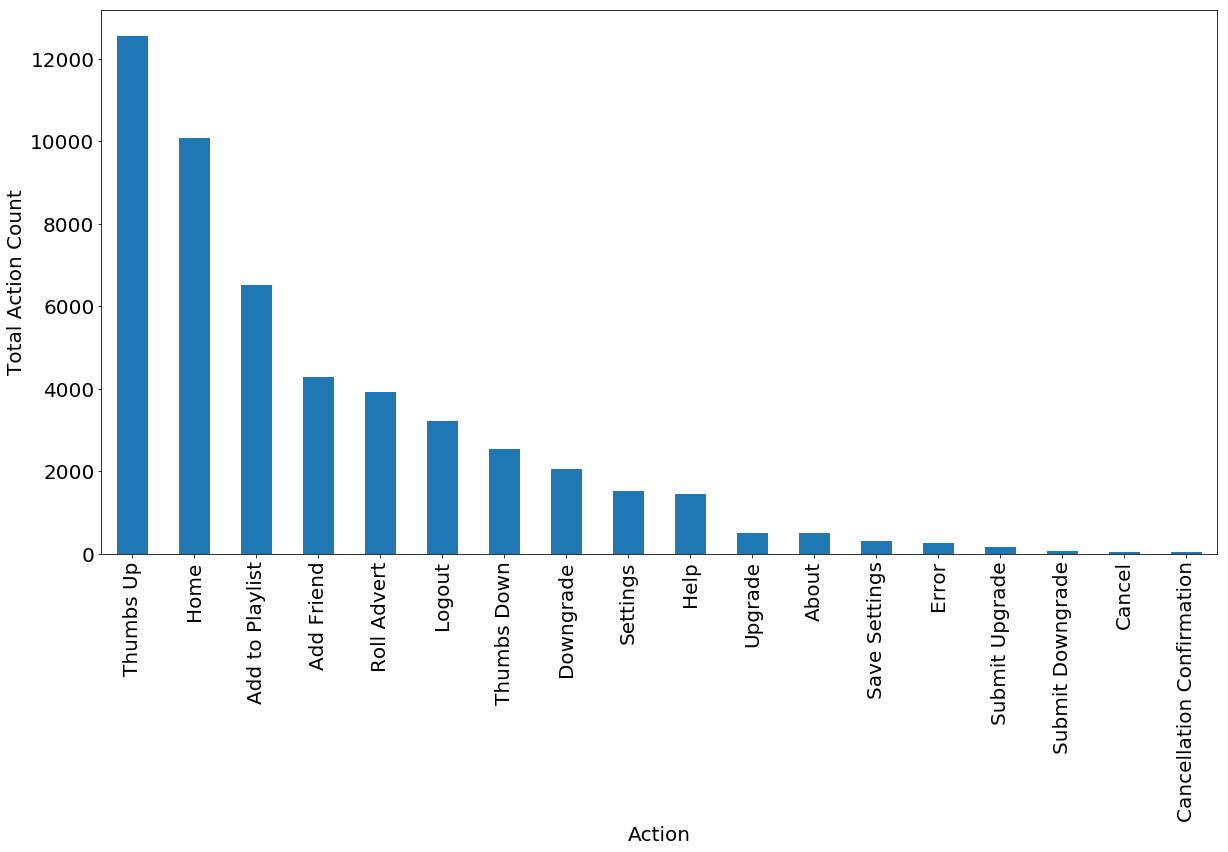

In [14]:
# actions performed when action is not "NextSong"
actions = df.select("page").filter(df.page!="NextSong").groupBy("page").agg({"page":"count"}).withColumnRenamed("Count(page)", "count").orderBy(col("count").desc()).toPandas()
actions.plot.bar(x="page", figsize=(20,10), legend=False, fontsize=20)
plt.xlabel("Action", fontsize=20)
plt.ylabel("Total Action Count", fontsize=20)
plt.show()

*Cancellation confirmation* is the page that shows up once a user has submitted a request to cease their subscription. Let's see what kind of subscription the users who decide to unsubscribe have, whether it be paid or free.

In [15]:
# number of cancellation by type
df.filter(df.page=="Cancellation Confirmation").select("level").groupby("level").agg({'level':'count'}).show()

+-----+------------+
|level|count(level)|
+-----+------------+
| free|          21|
| paid|          31|
+-----+------------+



### Define Churn

Let's now define a rule to determine churn users, i.e. those users who leave the service: these will be those users that list in `page` the voice *Cancellation Confirmation*.

In [16]:
# mark as churn those records with Cancellation Confirmation
make_churn = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", make_churn(df.page))

## Exploratory Data Analysis - After Churn Definition

We can now examine the behaviour of churn and not churn users and their differences.

In [17]:
# get lists of churn and not churn users, churn users have churn=1, whereas not churn users have churn=0
churn_users = np.array(df.select("userId").filter(df.churn==1).dropDuplicates().toPandas()["userId"])
users = np.array(df.select("userId").filter(df.churn==0).dropDuplicates().toPandas()["userId"])
not_churn_users = np.setdiff1d(users, churn_users)

not_churn_users = list(not_churn_users)
churn_users = list(churn_users)
n_churn_users = len(churn_users)
n_not_churn_users = len(not_churn_users)

print("No.churn users: ", n_churn_users, "\nNo. not churn users: ", n_not_churn_users)

No.churn users:  52 
No. not churn users:  173


Once we determined churn and not churn users, let's compare the average behaviours among the two groups of users.

In [18]:
# get dataframe of actions performed on average by a churn user, ordered in descending order
churn_df = df.filter(df.userId.isin(churn_users)).groupby("page").agg(count("page").alias("count")).orderBy(col("count").desc()).toPandas()
churn_df["count"] = round(churn_df["count"]/n_churn_users, 2)
churn_df

,page,count
0,NextSong,699.88
1,Thumbs Up,35.75
2,Home,32.15
3,Add to Playlist,19.96
4,Roll Advert,18.60
5,Add Friend,12.23
6,Logout,10.63
7,Thumbs Down,9.54
8,Downgrade,6.48
9,Settings,5.19


In [19]:
# get dataframe of actions performed on average by a not churn user, ordered in descending order
not_churn_df = df.filter(df.userId.isin(not_churn_users)).groupby("page").agg(count("page").alias("count")) \
    .orderBy(col("count").desc()).toPandas()
not_churn_df["count"] = round(not_churn_df["count"]/n_not_churn_users, 2)
not_churn_df

,page,count
0,NextSong,1108.17
1,Thumbs Up,61.80
2,Home,48.61
3,Add to Playlist,31.72
4,Add Friend,21.05
5,Roll Advert,17.14
6,Logout,15.45
7,Thumbs Down,11.85
8,Downgrade,9.93
9,Settings,7.19


In [20]:
# merge the dataframes of churn and not churn users behaviour
behaviour_df = churn_df.merge(not_churn_df, how="outer", on="page", suffixes=["_churn", "_not_churn"])
behaviour_df

,page,count_churn,count_not_churn
0,NextSong,699.88,1108.17
1,Thumbs Up,35.75,61.80
2,Home,32.15,48.61
3,Add to Playlist,19.96,31.72
4,Roll Advert,18.60,17.14
5,Add Friend,12.23,21.05
6,Logout,10.63,15.45
7,Thumbs Down,9.54,11.85
8,Downgrade,6.48,9.93
9,Settings,5.19,7.19


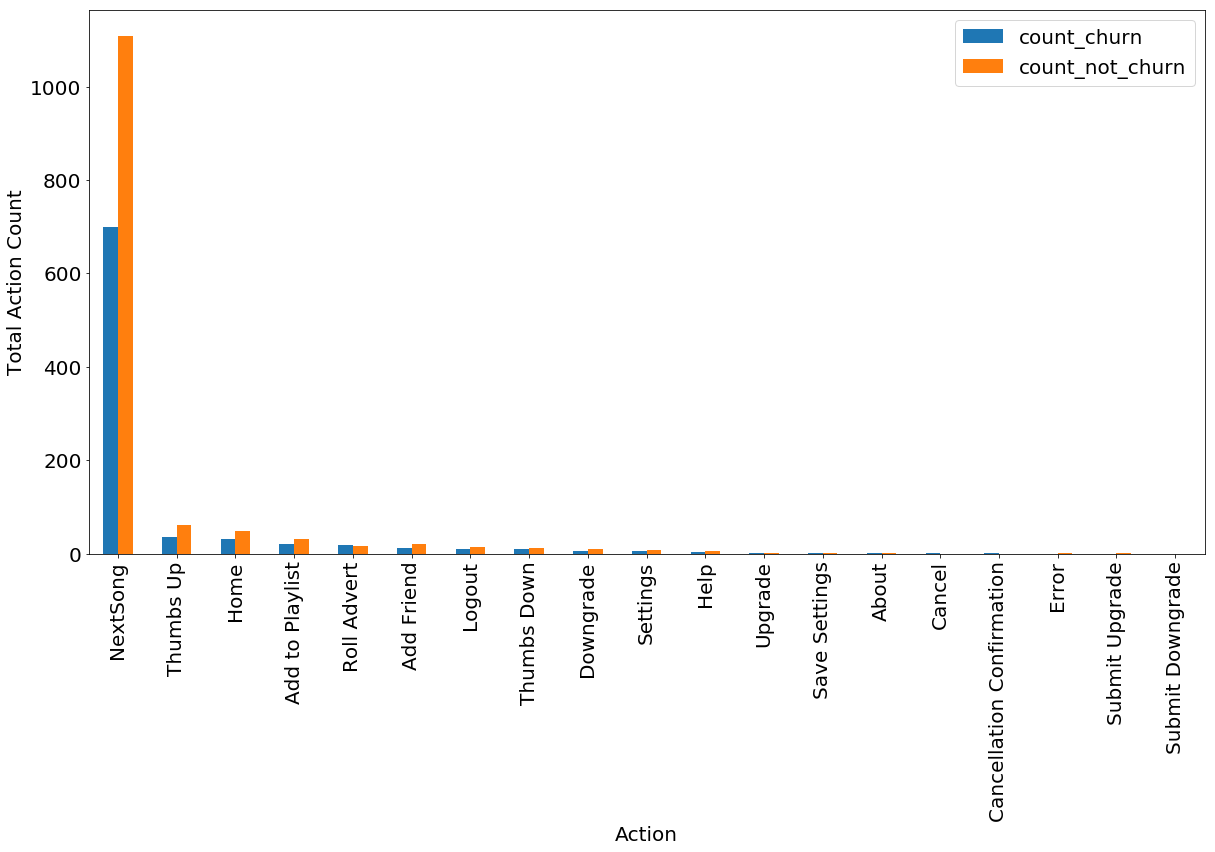

In [21]:
# plot the dataframe
behaviour_df.plot.bar(x="page", figsize=(20,10), legend=False, fontsize=20)
plt.legend(fontsize=20)
plt.ylabel("Total Action Count", fontsize=20)
plt.xlabel("Action", fontsize=20)
plt.show()

The plot above indicates that usually not churn users show a more involvement with the service than churn users.

Let's look now at churn and not churn users differences by `gender`.

In [22]:
# get number of users by gender for churn users
churn_gender = df.select("userId", "gender").filter(df.userId.isin(churn_users)).dropDuplicates() \
    .groupby("gender").agg(count("userId").alias("count")).orderBy(col("count").desc()).toPandas()

# get number of users by gender for not churn users
not_churn_gender = df.select("userId", "gender").filter(df.userId.isin(not_churn_users)).dropDuplicates() \
    .groupby("gender").agg(count("userId").alias("count")).orderBy(col("count").desc()).toPandas()

# merge the two dataframes 
gender_df = churn_gender.merge(not_churn_gender, how="outer", on="gender", suffixes=["_churn", "_not_churn"])

# get quantities by percentage
gender_df["count_churn [%]"] = round(gender_df["count_churn"]/n_churn_users*100, 2)
gender_df["count_not_churn [%]"] = round(gender_df["count_not_churn"]/n_not_churn_users*100, 2)
gender_df

,gender,count_churn,count_not_churn,count_churn [%],count_not_churn [%]
0,M,32,89,61.54,51.45
1,F,20,84,38.46,48.55


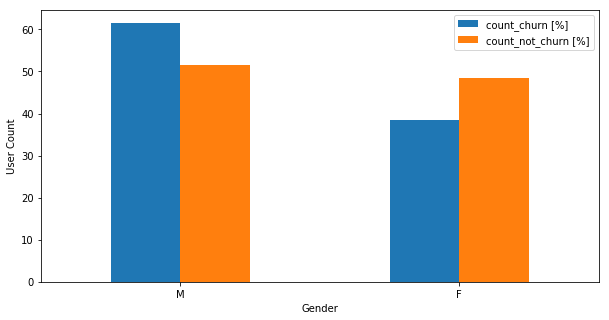

In [23]:
# plot the dataframe
gender_df[["gender", "count_churn [%]", "count_not_churn [%]"]].plot.bar(x="gender", figsize=(10,5), legend=False, fontsize=10, rot=0)
plt.legend(fontsize=10)
plt.xlabel('Gender', fontsize=10)
plt.ylabel("User Count", fontsize=10)
plt.show()

The proportion of male churn users is greater than the proportion of male users who do not churn. The opposite can be said for females, as the proportion of female churn users is less than the proportion of female not churn users. This means there's a higher chance of churn if the user is a male, and gender is very likely a factor to take into account when trying to predict churn.

Let's look now at behaviour differences within not churn users by `gender`.

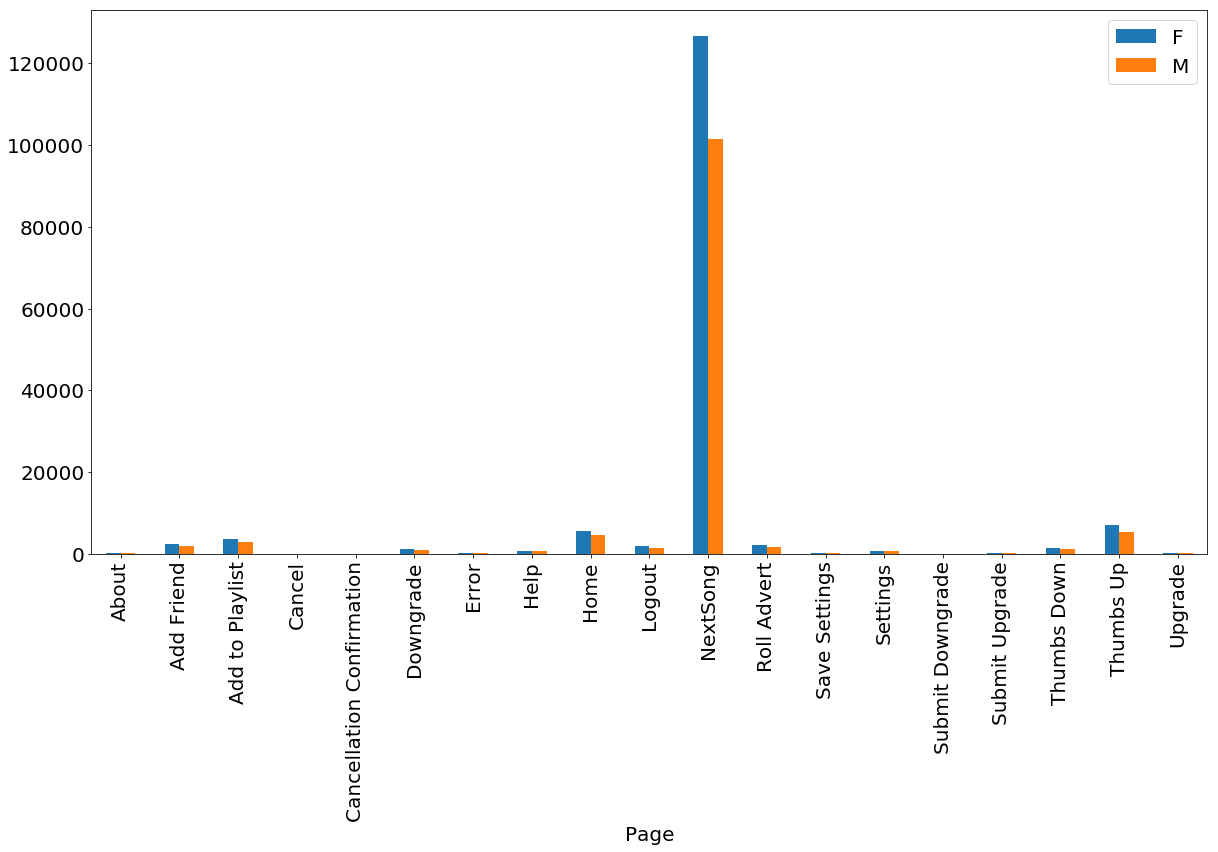

In [24]:
not_churn_gender_be = df.select("userId", "gender", "page").groupby("page", "gender").agg(count("userId").alias("count")).toPandas()
not_churn_gender_be_pivot = not_churn_gender_be.pivot(index="page", columns="gender", values="count").reset_index()
not_churn_gender_be_pivot.plot.bar(x="page", figsize=(20, 10), legend=False, fontsize=20, rot=90)
plt.legend(fontsize=20)
plt.xlabel('Page', fontsize=20)
plt.show()

We can see from the bar plot above that, on average, females are more active than males.

Since males are more likely to churn, let's examine the average behaviour of churn and not churn users for males and how it differs.

In [25]:
# get male churn and not churn users
male_churn_users = np.array(df.select("userId").filter((df.churn==1) & (df.gender=="M")).dropDuplicates().toPandas()["userId"])
male_users = np.array(df.select("userId").filter((df.churn==0) & (df.gender=="M")).dropDuplicates().toPandas()["userId"])
male_not_churn_users = np.setdiff1d(male_users, male_churn_users)

# get total number of male churn and not churn users 
male_not_churn = list(male_not_churn_users)
male_churn = list(male_churn_users)
n_male_churn = len(male_churn)
n_male_not_churn = len(male_not_churn)

# get actions performed on average by male churn users in descending order
male_churn_df = df.filter(df.userId.isin(male_churn)).groupby("page").agg(count("page").alias("count")) \
    .orderBy(col("count").desc()).toPandas()
male_churn_df["count"] = round(male_churn_df["count"]/n_male_churn, 2)

# get actions performed on average by male not churn users in descending order
male_not_churn_df = df.filter(df.userId.isin(male_not_churn)).groupby("page").agg(count("page").alias("count")) \
    .orderBy(col("count").desc()).toPandas()
male_not_churn_df["count"] = round(male_not_churn_df["count"]/n_male_not_churn, 2)

male_df = male_churn_df.merge(male_not_churn_df, how="outer", on="page", suffixes=["_churn", "_not_churn"])
male_df

,page,count_churn,count_not_churn
0,NextSong,654.81,904.02
1,Thumbs Up,32.03,49.53
2,Home,29.34,40.08
3,Add to Playlist,18.44,25.29
4,Roll Advert,16.06,14.21
5,Add Friend,11.19,16.74
6,Logout,10.03,12.47
7,Thumbs Down,8.84,9.93
8,Downgrade,5.75,8.34
9,Settings,5.00,6.16


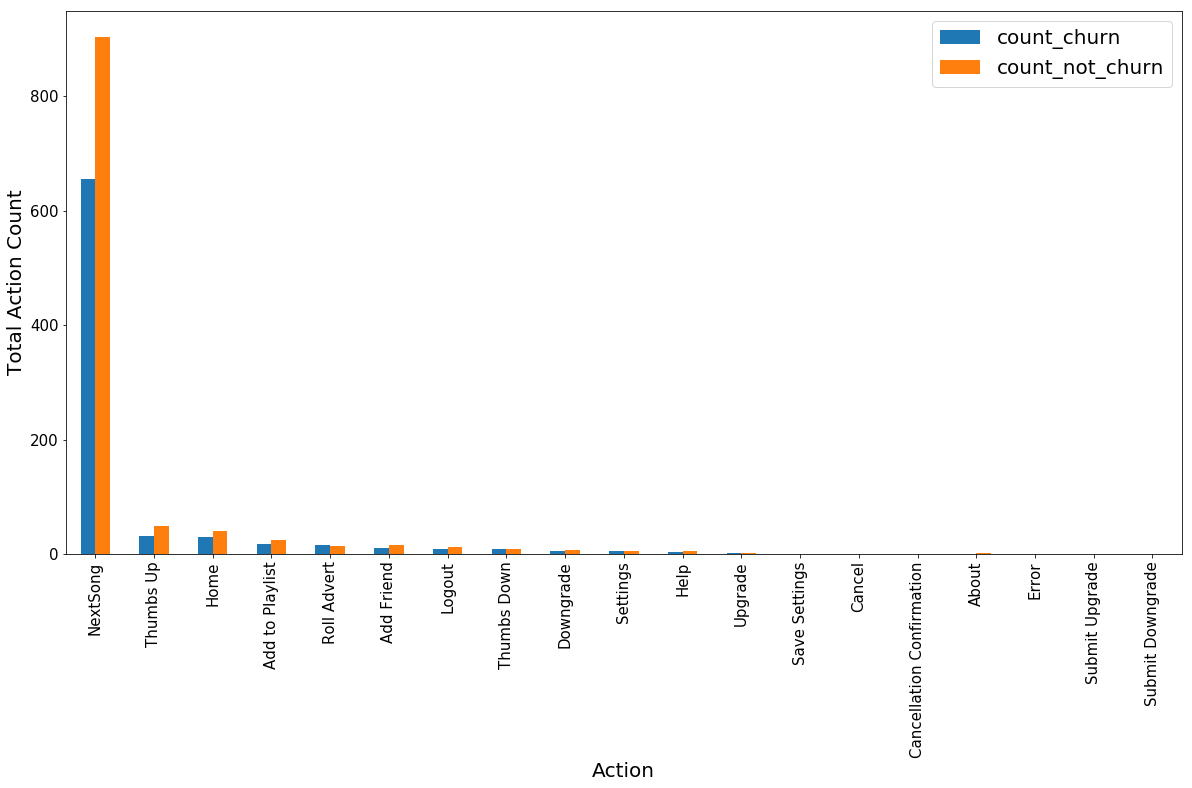

In [26]:
# plot the dataframe
male_df.plot.bar(x="page", figsize=(20,10), legend=False, fontsize=15, rot=90)
plt.legend(fontsize=20)
plt.xlabel('Action', fontsize=20)
plt.ylabel("Total Action Count", fontsize=20)
plt.show()

In [27]:
# get quantities by percentage and percentage difference in behaviour
male_df["count_churn [%]"] = round(male_df["count_churn"]/male_df["count_churn"].sum()*100, 2)
male_df["count_not_churn [%]"] = round(male_df["count_not_churn"]/male_df["count_not_churn"].sum()*100, 2)
male_df["difference"] = male_df["count_churn [%]"] - male_df["count_not_churn [%]"]
male_df

,page,count_churn,count_not_churn,count_churn [%],count_not_churn [%],difference
0,NextSong,654.81,904.02,81.55,82.20,-0.65
1,Thumbs Up,32.03,49.53,3.99,4.50,-0.51
2,Home,29.34,40.08,3.65,3.64,0.01
3,Add to Playlist,18.44,25.29,2.30,2.30,0.00
4,Roll Advert,16.06,14.21,2.00,1.29,0.71
5,Add Friend,11.19,16.74,1.39,1.52,-0.13
6,Logout,10.03,12.47,1.25,1.13,0.12
7,Thumbs Down,8.84,9.93,1.10,0.90,0.20
8,Downgrade,5.75,8.34,0.72,0.76,-0.04
9,Settings,5.00,6.16,0.62,0.56,0.06


The column difference above shows the comparison of the average behaviour of churn and not churn male users. Where the values are positive, it means that that particular action has been taken more from the churn group, while negative values show those actions that were performed less freuently.
We can see that, in general, churn users have more home visits, adverts being rolled, logouts, thumbs down, and more interactions with settings and help pages. This could mean that churn happens when there's a bit of struggle with the settings, the songs availbale aren't of a user liking and there are too many adverts. 
Another thing is that upgrade actions are done more by churn users. This means that once they upgraded, they still didn't like the service and decided to cancel the service anyway.

In [28]:
#Let's now look at the difference in `level` between churn and not churn users.

In [29]:
# churn_level = df.select("userId", "level").filter(df.userId.isin(churn_users)).dropDuplicates() \
#     .groupby("level").agg({"userId":"count"}).withColumnRenamed("Count(userId)", "count").orderBy(col("count").desc()).toPandas()
# not_churn_level = df.select("userId", "level").filter(df.userId.isin(not_churn_users)).dropDuplicates() \
#     .groupby("level").agg({"userId":"count"}).withColumnRenamed("Count(userId)", "count").orderBy(col("count").desc()).toPandas()

# level_df = churn_level.merge(not_churn_level, how="outer", on="level", suffixes=["_churn", "_not_churn"])
# level_df["count_churn [%]"] = round(level_df["count_churn"]/n_churn_users*100, 2)
# level_df["count_not_churn [%]"] = round(level_df["count_not_churn"]/n_not_churn_users*100, 2)
# level_df

Let's see now if the variables `location` and `userAgent` play any role in determining churn. We want to see if particular values of these variables result into a higher churn probability.

In [30]:
# get dataframes of number of occurence of each location for churn and not churn users
churn_location = df.select("userId", "location").filter(df.userId.isin(churn_users)).dropDuplicates() \
    .groupby("location").agg({"userId":"count"}).withColumnRenamed("Count(userId)", "count").orderBy(col("count").desc()).toPandas()
not_churn_location = df.select("userId", "location").filter(df.userId.isin(not_churn_users)).dropDuplicates() \
    .groupby("location").agg({"userId":"count"}).withColumnRenamed("Count(userId)", "count").orderBy(col("count").desc()).toPandas()

# merge the two dataframes and get count values by percentage
location_df = churn_location.merge(not_churn_location, how="outer", on="location", suffixes=["_churn", "_not_churn"])
location_df["count_churn [%]"] = round(location_df["count_churn"]/n_churn_users*100, 2)
location_df["count_not_churn [%]"] = round(location_df["count_not_churn"]/n_not_churn_users*100, 2)
location_df.head()

,location,count_churn,count_not_churn,count_churn [%],count_not_churn [%]
0,"New York-Newark-Jersey City, NY-NJ-PA",5.0,10.0,9.62,5.78
1,"Los Angeles-Long Beach-Anaheim, CA",3.0,13.0,5.77,7.51
2,"Phoenix-Mesa-Scottsdale, AZ",2.0,5.0,3.85,2.89
3,"Miami-Fort Lauderdale-West Palm Beach, FL",2.0,3.0,3.85,1.73
4,"Jackson, MS",2.0,NaN,3.85,NaN


In [31]:
# get dataframes of number of occurence of each userAgent for churn and not churn users
churn_agent = df.select("userId", "userAgent").filter(df.userId.isin(churn_users)).dropDuplicates() \
    .groupby("userAgent").agg({"userId":"count"}).withColumnRenamed("Count(userId)", "count").orderBy(col("count").desc()).toPandas()
not_churn_agent = df.select("userId", "userAgent").filter(df.userId.isin(not_churn_users)).dropDuplicates() \
    .groupby("userAgent").agg({"userId":"count"}).withColumnRenamed("Count(userId)", "count").orderBy(col("count").desc()).toPandas()

# merge the two dataframes and get count values by percentage
agent_df = churn_agent.merge(not_churn_agent, how="outer", on="userAgent", suffixes=["_churn", "_not_churn"])
agent_df["count_churn [%]"] = round(agent_df["count_churn"]/n_churn_users*100, 2)
agent_df["count_not_churn [%]"] = round(agent_df["count_not_churn"]/n_not_churn_users*100, 2)
agent_df.head()

,userAgent,count_churn,count_not_churn,count_churn [%],count_not_churn [%]
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",5.0,11.0,9.62,6.36
1,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",5.0,19.0,9.62,10.98
2,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,4.0,14.0,7.69,8.09
3,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",4.0,4.0,7.69,2.31
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",3.0,7.0,5.77,4.05


For `userAgent` and `location`, it's really difficult to tell whether there's a difference between churn and not churn users. The churn users most frequent locations are the same as the not churn users. The same can be said about `userAgent`. Furthermore, there's not enough data of churn users to determine whether a particular `location` or `userAgent` can affect user churn. Thus, these features will likely be discarded when trying to predict churn.

For all the categorical variables, i.e. `gender`, `level`, `userAgent` and `location`, let's see if these variables have unique values for each user.

In [32]:
# check how many different values there are for each user for categorical variables
unique_check = df.groupby("userId").agg(countDistinct("gender").alias("gender"),\
                        countDistinct("level").alias("level"),\
                        countDistinct("userAgent").alias("userAgent"),\
                        countDistinct("location").alias("location")).toPandas()
unique_check.describe()

,gender,level,userAgent,location
count,225.0,225.00000,225.0,225.0
mean,1.0,1.60000,1.0,1.0
std,0.0,0.49099,0.0,0.0
min,1.0,1.00000,1.0,1.0
25%,1.0,1.00000,1.0,1.0
50%,1.0,2.00000,1.0,1.0
75%,1.0,2.00000,1.0,1.0
max,1.0,2.00000,1.0,1.0


`gender`, `userAgent`, and `location` have only one value per user, while `level` is not unique for each user. Therefore, we can consider `gender`, `userAgent`, and `location` as fixed variable, and for `level` we will do different considerations later.

## Feature Engineering

We will prepare the dataset for the predictive analysis in two steps. The first step consists in getting all the categorical and fixed variables, i.e. those variables that do not change for each user, like `gender`, `location`, `userAgent`. We will create a dataframe with each user having one row and their respective values for these variables. To get these variables we will simply take their values at the last record of each user.

In [33]:
# get last record for each user, so the record with the greatest timestamp
lookup = df.groupby("userId").agg({"ts":"max"}).withColumnRenamed("MAX(ts)", "time").withColumnRenamed("userId", "user")
categorical_df = df.join(lookup, [df.ts == lookup.time, df.userId == lookup.user])
categorical_df.head(2)

[Row(artist=None, auth='Logged In', firstName='Michael', gender='M', itemInSession=14, lastName='Miller', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='PUT', page='Thumbs Up', registration=1537014411000, sessionId=2224, song=None, status=307, ts=1543190677000, userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:31.0) Gecko/20100101 Firefox/31.0', userId='60', churn=0, user='60', time=1543190677000),
 Row(artist=None, auth='Cancelled', firstName='Delaney', gender='F', itemInSession=23, lastName='Perez', length=None, level='free', location='Miami-Fort Lauderdale-West Palm Beach, FL', method='GET', page='Cancellation Confirmation', registration=1534627466000, sessionId=53, song=None, status=200, ts=1538498205000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='100001', churn=1, user='100001', time=1538498205000)]

Once we defined the categorical dataframe, let's check if there are any duplicates, as this dataframe should display one row per each user.

In [34]:
# check if categorical df has any user with more than one row
categorical_df.groupby("userId").agg(count("userId").alias("count")).orderBy(col("count").desc()).head(5)

[Row(userId='125', count=2),
 Row(userId='127', count=2),
 Row(userId='7', count=1),
 Row(userId='200002', count=1),
 Row(userId='51', count=1)]

It seems that users 125 and 127 have two rows each, let's check why.

In [35]:
categorical_df.filter(df.userId=="127").head(5)

[Row(artist='Rosie Vela', auth='Logged In', firstName='Aurora', gender='F', itemInSession=118, lastName='Humphrey', length=254.77179, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1536795126000, sessionId=2343, song='Magic Smile', status=200, ts=1543351229000, userAgent='"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='127', churn=0, user='127', time=1543351229000),
 Row(artist=None, auth='Logged In', firstName='Aurora', gender='F', itemInSession=119, lastName='Humphrey', length=None, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='GET', page='Home', registration=1536795126000, sessionId=2343, song=None, status=200, ts=1543351229000, userAgent='"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='127', churn=0, user='127', time=1543351229000)]

It seems that some users have more than one record displayed because the data show that there are two different action performed at the same time. To avoid this, we can remove `page` from this dataset, and we will include only those variables that we consider categorical and thus remove duplicate rows.

Before we remove `page`, the first feature to be calculated will be the number of days passed from the moment of registration for each user, i.e. how long the user has used the service at the time of the last event recorded for the user.

In [36]:
# calculate the difference in timestamp of each record from the registration timestamp
categorical_df = categorical_df.withColumn("rgstr_time", col("ts") - col("registration"))

# define a user funtion that transforms timestamp in days
diff_days = udf(lambda x: round(x/1000.0/3600.0/24.0, 2), DoubleType())

# calculate the new column
categorical_df = categorical_df.withColumn("days_since_registration", diff_days(categorical_df.rgstr_time))
categorical_df.head(2)

[Row(artist=None, auth='Logged In', firstName='Michael', gender='M', itemInSession=14, lastName='Miller', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='PUT', page='Thumbs Up', registration=1537014411000, sessionId=2224, song=None, status=307, ts=1543190677000, userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:31.0) Gecko/20100101 Firefox/31.0', userId='60', churn=0, user='60', time=1543190677000, rgstr_time=6176266000, days_since_registration=71.48),
 Row(artist=None, auth='Cancelled', firstName='Delaney', gender='F', itemInSession=23, lastName='Perez', length=None, level='free', location='Miami-Fort Lauderdale-West Palm Beach, FL', method='GET', page='Cancellation Confirmation', registration=1534627466000, sessionId=53, song=None, status=200, ts=1538498205000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='100001', churn=1, user='100001', time=15384982

Let's create a dataset of the fixed variables for each user: it will contain information such as `gender`, `location`, `userAgent` and `days_since_registration`. 

In [37]:
# select only relevant columns
categorical_df = categorical_df.select("gender", "location", "level", "userAgent", "user", 
                                       "days_since_registration").dropDuplicates()
categorical_df.head(1)

[Row(gender='M', location='Philadelphia-Camden-Wilmington, PA-NJ-DE-MD', level='paid', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', user='79', days_since_registration=76.06)]

In [38]:
# check again if there are any duplicates
categorical_df.groupby("user").agg(count("user").alias("count")).orderBy(col("count").desc()).show(5)

+------+-----+
|  user|count|
+------+-----+
|200002|    1|
|100010|    1|
|   125|    1|
|     7|    1|
|   124|    1|
+------+-----+
only showing top 5 rows



We can see that there are no duplicate rows now, as intended.

The second step to create the dataframe for the predictive analysis will be to calculate the numerical features. These features will comprehend varibales like number of songs played, total seconds of songs listened, total thumbs up, total thumbs down, whether the user has upgraded, dowgraded, had a paid service, and has cancelled the subscription.

In [39]:
# define the user functions to calculate the variables written above
is_thumbs_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
is_thumbs_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
has_upgraded = udf(lambda x: 1 if x == "Upgrade" else 0, IntegerType())
has_downgraded = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
is_song = udf(lambda x: 1 if x is not None else 0, IntegerType())
has_been_paid = udf(lambda x:1 if x == "paid" else 0, IntegerType())

# calculate the new columns
df_clean = df.withColumn("thumbsUp", is_thumbs_up(df.page))\
    .withColumn("thumbsDown", is_thumbs_down(df.page))\
    .withColumn("upgraded", has_upgraded(df.page))\
    .withColumn("downgraded", has_downgraded(df.page))\
    .withColumn("songCheck", is_song(df.song))\
    .withColumn("paid", has_been_paid(df.level))

Like for the categorical dataset, the objective is to obtain a dataset with one row per each user. Therefore, group by operations are needed in order to summarize the numerical variabales that were just calculated.

In [40]:
numerical_df = df_clean.groupBy("userId").agg(Fsum("songCheck").alias("total_songs"),\
                                              Fsum("thumbsUp").alias("total_likes"),\
                                              Fsum("thumbsDown").alias("total_dislikes"),\
                                              max("upgraded").alias("upgrade"),\
                                              max("downgraded").alias("downgrade"),\
                                              Fround(Fsum("length"),2).alias("total_seconds"),\
                                              max("paid").alias("paid"),\
                                              max("churn").alias("churn"))
numerical_df.show(1)

+------+-----------+-----------+--------------+-------+---------+-------------+----+-----+
|userId|total_songs|total_likes|total_dislikes|upgrade|downgrade|total_seconds|paid|churn|
+------+-----------+-----------+--------------+-------+---------+-------------+----+-----+
|100010|        275|         17|             5|      1|        0|      66940.9|   0|    0|
+------+-----------+-----------+--------------+-------+---------+-------------+----+-----+
only showing top 1 row



In [41]:
# check the number of records, see if there are all users (225)
numerical_df.count()

225

Performed the two steps, it's time to merge the categorical and numerical dataframes to get a new dataframe, which will be used for the predictive analysis.

In [42]:
# join the two dataframes
ml_df = numerical_df.join(categorical_df, [numerical_df.userId == categorical_df.user])

In [43]:
ml_df.head(5)

[Row(userId='100010', total_songs=275, total_likes=17, total_dislikes=5, upgrade=1, downgrade=0, total_seconds=66940.9, paid=0, churn=0, gender='F', location='Bridgeport-Stamford-Norwalk, CT', level='free', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', user='100010', days_since_registration=55.64),
 Row(userId='200002', total_songs=387, total_likes=21, total_dislikes=6, upgrade=1, downgrade=1, total_seconds=94008.88, paid=1, churn=0, gender='M', location='Chicago-Naperville-Elgin, IL-IN-WI', level='paid', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D167 Safari/9537.53"', user='200002', days_since_registration=70.07),
 Row(userId='125', total_songs=8, total_likes=0, total_dislikes=0, upgrade=0, downgrade=0, total_seconds=2089.11, paid=0, churn=1, gender='M', location='Corpus Christi, TX', level='fre

# Modelling

Now that the dataframe is ready for the analysis, let's do some correlation analysis and see which variables are the most suitable for our purpose.

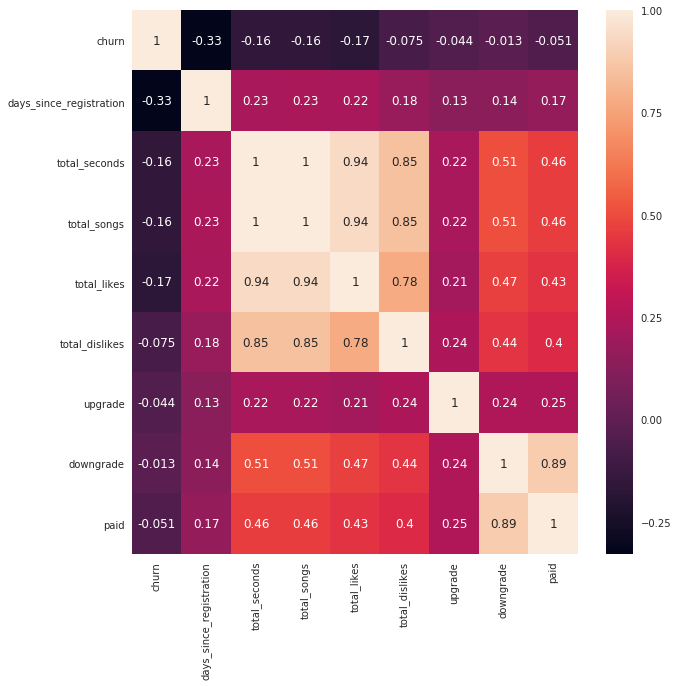

In [44]:
# correlation analysis among the numerical features and churn variable
corr_df = ml_df.select("churn", "days_since_registration", "total_seconds", "total_songs", "total_likes", "total_dislikes", "upgrade", "downgrade", "paid").toPandas()
sns.set(rc={'figure.figsize':(10,10)},font_scale=1)

# plot correlation matrix
sns.heatmap(corr_df.corr(), annot=True)

`total_songs` and `total_seconds` are the same in term of correlation, therefore we need only one of the two. Also `total_likes` and `total_dislikes` are pretty similar, therefore we can keep only one. We'll keep only `total_likes`, as it has a higher correlation with `churn`. Furthermore, from the analysis above, we saw that we can't really determine the influence of `location` and `userAgent` on `churn`, therefore we are going to exclude these columns from the analysis.

Let's write a function to assemble the data and make it ready for a machine learning model. Since there are categorical varibables, transformers like *StringIndexer* and *OneHotEncoder* will be needed. Then, all the variables, numerical and categorical, will be assembled into a vector column with *VectorAssembler*, and a pipeline that go through all these steps will be used to fit the data and create a "feature" vector columnn, needed for the analysis.

In [45]:
def assemble_ml_data(numeric_cols, index_cols, ml_df):
    '''
    This function takes as input a list of numerical columns, a list of categorical columns, and a PySpark dataframe and it
    performs indexing and one hot encoding on the categorical columns, assembles the categorical and numerical columns into a 
    vector column that can be used for machine learning modelling with PySpark.
    
    Input:
    numeric_cols - a list of column names that contain numerical values
    index_cols - a list of column names that contain categorical values
    ml_df - a PySpark dataframe
    
    Output:
    data - a PySpark dataframe which contains a vector column and is suitable for machine learning modelling with PySpark
    
    '''
    
    # indexers and econders needed to deal with categorical variables
    indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid='keep') for col_name in index_cols]
    encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), 
                          outputCol="{}_ohe".format(indexer.getOutputCol())) for indexer in indexers]

    # collect all variables, categorical and numerical and assemble them into a vector column
    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + numeric_cols, outputCol="vecfeatures")
    p_stages = indexers + encoders + [assembler]

    pipeline = Pipeline(stages = p_stages)
    data = pipeline.fit(ml_df).transform(ml_df)
    
    return data

Let's put the function into action.

In [46]:
# numeric and categorical columns that will be kept
numeric_cols = ["days_since_registration", "total_songs", "total_likes", "upgrade", "downgrade", "paid"]
index_cols = ["gender", "level"]
ml_df = ml_df.select("userId", "gender", "level", "days_since_registration", "total_songs", 
                     "total_likes", "upgrade", "downgrade", "paid", "churn")

# caching dataset to obtain samme split when applying randomSplit() multiple times
ml_df = ml_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
ml_df.head(3)

[Row(userId='100010', gender='F', level='free', days_since_registration=55.64, total_songs=275, total_likes=17, upgrade=1, downgrade=0, paid=0, churn=0),
 Row(userId='200002', gender='M', level='paid', days_since_registration=70.07, total_songs=387, total_likes=21, upgrade=1, downgrade=1, paid=1, churn=0),
 Row(userId='125', gender='M', level='free', days_since_registration=71.32, total_songs=8, total_likes=0, upgrade=0, downgrade=0, paid=0, churn=1)]

In [47]:
data = assemble_ml_data(numeric_cols, index_cols, ml_df)
data.head(2)

[Row(userId='100010', gender='F', level='free', days_since_registration=55.64, total_songs=275, total_likes=17, upgrade=1, downgrade=0, paid=0, churn=0, gender_index=1.0, level_index=1.0, gender_index_ohe=SparseVector(2, {1: 1.0}), level_index_ohe=SparseVector(2, {1: 1.0}), vecfeatures=DenseVector([0.0, 1.0, 0.0, 1.0, 55.64, 275.0, 17.0, 1.0, 0.0, 0.0])),
 Row(userId='200002', gender='M', level='paid', days_since_registration=70.07, total_songs=387, total_likes=21, upgrade=1, downgrade=1, paid=1, churn=0, gender_index=0.0, level_index=0.0, gender_index_ohe=SparseVector(2, {0: 1.0}), level_index_ohe=SparseVector(2, {0: 1.0}), vecfeatures=DenseVector([1.0, 0.0, 1.0, 0.0, 70.07, 387.0, 21.0, 1.0, 1.0, 1.0]))]

Once the data is ready to be fed into a machine learning model, we will feed it to a pipeline that comprehends a *StandardScaler* and a *Classifier*, which will be chosen among three algorithms: **Random Forest (RF)**, **Linear Regression (LR)** and **Linear SVC (LSVC)**. We will write a function that goes through all these steps and also adds the possibility to use *CrossValidation*, in order to be able to do parameter tuning for our chosen model.

In [48]:
def make_prediction(data, transformer=None, paramGrid=None):
    '''
    This function takes as input a PySpark dataframe with vector feature column, and make a prediction on the target value based
    on the transformer used. The transformer is tuned using the paramGrid with cross-validation.
    
    Input:
    data - a PySpark datafram with a vector feature column
    transformer - a transformer to make label prediction on the target value (i.e. LogisticRegression, RandomForestClassifier)
    paramGrid - a set of parameters used for tuning, it must be a PramGridBuilder instance
    
    Output:
    results - a PySpark dataframe containing the results of the prediction process in the column "prediction"
    '''
    
    # split data into train and test sets and set the pipeline
    train, test = data.randomSplit([0.8, 0.2], seed=42)
    standardscaler = StandardScaler(inputCol="vecfeatures", outputCol="features", withMean=True, withStd=True)
    pipeline = Pipeline(stages=[standardscaler, transformer])
    
    # if a parameter grid is passed, the function gives the possibility to perform cross-validation
    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3)
    
        model = crossval.fit(train.withColumnRenamed("churn", "label"))
    else:
        model = pipeline.fit(train.withColumnRenamed("churn", "label"))
    
    results = model.transform(test)
    
    # output both the model and the dataset with the prediction column
    return model, results

Now we only need a function to evaluate the goodness of the model. We will look at several metrics to score our models, as **accuracy** alone is not realiable in those cases where there's a class imbalance. In this case, for example, the number of not churn users is way bigger than the number of churn users. Using **accuracy** only may lead to the model labelling every users as not churn, since they represents the majority, and still performing well. We will focus then on other three metrics: **precision**, **recall** and **f1score**. *sklearn* classification reports comes in handy for this purpose, as it allows to see the values of all the metrics mentioned for each predicted class in the dataset.

In [49]:
def evaluation_metrics(results, label_col="label", pred_col="prediction"):
    
    pandas_df = results.select(label_col, pred_col).toPandas()
    print("Accuracy: ", sum(pandas_df[label_col] == pandas_df[pred_col])/pandas_df.shape[0])
    print(classification_report(np.array(pandas_df[label_col]), np.array(pandas_df[pred_col])))

Now that all the necessary functions are defined, let's feed our data to different transformer (**RF**, **LR**, **LSVC**).

#### Random Forest

In [50]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

model, results_rf = make_prediction(data, rf)

In [51]:
# f1 = MulticlassClassificationEvaluator().evaluate(results_rf.withColumnRenamed("churn", "label"))
# print("f1 for Random Forest: ", f1)

In [52]:
evaluation_metrics(results_rf, "churn", "prediction")

Accuracy:  0.7647058823529411
             precision    recall  f1-score   support

          0       0.78      0.96      0.86        26
          1       0.50      0.12      0.20         8

avg / total       0.72      0.76      0.71        34



#### Linear Regression

In [53]:
lr = LogisticRegression(labelCol="label", featuresCol="features")

model, results_lr = make_prediction(data, lr)

In [54]:
evaluation_metrics(results_lr, "churn", "prediction")

Accuracy:  0.8529411764705882
             precision    recall  f1-score   support

          0       0.84      1.00      0.91        26
          1       1.00      0.38      0.55         8

avg / total       0.88      0.85      0.83        34



#### Linear SVC

In [55]:
LSVC = LinearSVC(labelCol="label", featuresCol="features")

model, results_svc = make_prediction(data, LSVC)

In [56]:
evaluation_metrics(results_svc, "churn", "prediction")

Accuracy:  0.7647058823529411
             precision    recall  f1-score   support

          0       0.76      1.00      0.87        26
          1       0.00      0.00      0.00         8

avg / total       0.58      0.76      0.66        34



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


From the results above, the best algoirthms are Linear Regression and Random Forest.

|model|accuracy|precision|recall|f1 score|
|---|---|---|---|---|
|RF|0.82|0.86|0.82|0.78|
|LR|0.85|0.88|0.85|0.83|
|LSVC|0.77|0.58|0.76|0.66|

# Model Tuning And Refinement

The number of churn user is relately small compared to the total number of user in the dataset and from the results of the cells above, it seems that the algorithms can't detect well churn users, which is likely due to class imbalance. Let's try to introduce label weights, in order to equilibrate the presence of churn and not churn users.

In [57]:
# let's calculate weights for churn and not churn users
churn_weight = n_not_churn_users/(n_churn_users + n_not_churn_users)
not_churn_weight = n_churn_users/(n_churn_users + n_not_churn_users)

# get weight column for the dataframe
label_weight = udf(lambda x: churn_weight if x==1 else not_churn_weight, DoubleType())
data = data.withColumn("weight", label_weight(data.churn))
data.select("churn", "weight").head(5)

[Row(churn=0, weight=0.2311111111111111),
 Row(churn=0, weight=0.2311111111111111),
 Row(churn=1, weight=0.7688888888888888),
 Row(churn=0, weight=0.2311111111111111),
 Row(churn=1, weight=0.7688888888888888)]

Now that we have the weight column, let's see how results change. We will look at only Linear Regression, as the current spark version we are using does not allow to have a weight column for Random Forest. Moreover, we will also tune the model with *CrossValidation*.

In [58]:
lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="weight")

# define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01, 0.05, 0.1, 0.5, 1]) \
    .addGrid(lr.threshold,[0.3, 0.4, 0.5]) \
    .build()


model, results = make_prediction(data, lr, paramGrid)

In [59]:
evaluation_metrics(results, "churn", "prediction")

Accuracy:  0.7352941176470589
             precision    recall  f1-score   support

          0       0.87      0.77      0.82        26
          1       0.45      0.62      0.53         8

avg / total       0.77      0.74      0.75        34



|model|accuracy|precision|recall|f1 score|
|---|---|---|---|---|
|LR|0.74|0.77|0.74|0.75|

In [60]:
# let's see which parameters gave the best results
model.bestModel.stages[-1].extractParamMap()

{Param(parent='LogisticRegression_166c6041de21', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_166c6041de21', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_166c6041de21', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_166c6041de21', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_166c6041de21', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_166c6041de21', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_166c6041de21', name='maxIter', doc='maximum number of iterations (>= 0)'): 

From the output of the cell above, the two parameters chosen for tuning, **regParam** and **threshold**, have respectively the values of 0 and 0.5, which are the default values.

# A Different Approach

We focused until now on getting total variables like number of songs playes, total songs liked, disliked. Let's try a different approach, where instead of total songs and total likes we focus on the average number of songs per session, the number of sessions played, the gap between sessions, the average number of likes and dislikes per session, etc.. The numerical features of the dataset will be different then.

In [64]:
# the user defined functions are the same as above
is_thumbs_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
is_thumbs_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
has_upgraded = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
has_downgraded = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
is_song = udf(lambda x: 1 if x is not None else 0, IntegerType())
has_been_paid = udf(lambda x:1 if x == "paid" else 0, IntegerType())

df_ses = df.withColumn("thumbsUp", is_thumbs_up(df.page))\
    .withColumn("thumbsDown", is_thumbs_down(df.page))\
    .withColumn("upgraded", has_upgraded(df.page))\
    .withColumn("downgraded", has_downgraded(df.page))\
    .withColumn("songCheck", is_song(df.song))\
    .withColumn("paid", has_been_paid(df.level))
    

df_ses.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, rgstr_time=178755000, days_since_registration=2.07, thumbsUp=0, thumbsDown=0, upgraded=0, downgraded=0, songCheck=1, paid=1)

Differently from before, we will consider the `sessionId` variable, and summarize the different features based on the sessions. Variables like `total_songs`, `total_likes`, `total_dislikes` will be now average songs, avergae number of likes, and average number of dislikes per session.

In [65]:
df_ses = df_ses.select("userId", "sessionId", "churn", "ts", "rgstr_time", "thumbsUp", "thumbsDown",
              "upgraded", "downgraded", "songCheck", "paid") # no use of song length because of correlation seen before

# the group by is now done both at the user and session level
df_user_ses = df_ses.groupby("userId", "sessionId").agg(max("churn").alias("churn"),\
                                          min("ts").alias("ses_start"),\
                                          max("ts").alias("ses_end"),\
                                          Fsum("thumbsUp").alias("thumbsUp"),\
                                          Fsum("thumbsDown").alias("thumbsDown"),\
                                          Fsum("upgraded").alias("upgraded"),\
                                          Fsum("downgraded").alias("downgraded"),\
                                          Fsum("songCheck").alias("num_songs"),\
                                          max("paid").alias("paid"))

df_user_ses = df_user_ses.withColumn("sessionDuration_hours", (col("ses_end") - col("ses_start"))/1000.0/3600.0)
df_user_ses.orderBy("userId").head(2)

[Row(userId='10', sessionId=9, churn=0, ses_start=1538965220000, ses_end=1538979372000, thumbsUp=3, thumbsDown=0, upgraded=0, downgraded=0, num_songs=57, paid=1, sessionDuration_hours=3.931111111111111),
 Row(userId='10', sessionId=1047, churn=0, ses_start=1540850546000, ses_end=1540856031000, thumbsUp=2, thumbsDown=0, upgraded=0, downgraded=0, num_songs=21, paid=1, sessionDuration_hours=1.523611111111111)]

The extra step will be in this case the calculation of the gap between sessions, `sessiongap_hours`, which can be done by getting the start and end date of each session.

In [66]:
# create window function
user_window = Window \
   .partitionBy("userID") \
   .orderBy(asc("ses_start"))

# get the timestamp at the end of the previous session
df_user_ses = df_user_ses.withColumn("prev_ses_end", lag(col("ses_end")).over(user_window))
# calculate session gap as the difference between the start date of the current session and the end date of the previous one
df_user_ses = df_user_ses.withColumn("sessiongap_hours", (col("ses_start") - col("prev_ses_end"))/1000.0/3600.0)
df_user_ses.orderBy("userId", asc("ses_start")).head(2)

[Row(userId='10', sessionId=9, churn=0, ses_start=1538965220000, ses_end=1538979372000, thumbsUp=3, thumbsDown=0, upgraded=0, downgraded=0, num_songs=57, paid=1, sessionDuration_hours=3.931111111111111, prev_ses_end=None, sessiongap_hours=None),
 Row(userId='10', sessionId=595, churn=0, ses_start=1539833923000, ses_end=1539926798000, thumbsUp=23, thumbsDown=4, upgraded=0, downgraded=0, num_songs=381, paid=1, sessionDuration_hours=25.79861111111111, prev_ses_end=1538979372000, sessiongap_hours=237.37527777777777)]

Let's summarize now all the features to otbain an average situation of a general session for each user.  

In [67]:
# summarize all the features as average per session
df_user = df_user_ses.groupby("userId").agg(max("churn").alias("churn"),\
                               count("sessionId").alias("num_sessions"),\
                               Fround(avg("thumbsUp"),2).alias("avg_thumbsUp"),\
                               Fround(avg("thumbsDown"),2).alias("avg_thumbsDown"),\
                               Fsum("upgraded").alias("total_upgrades"),\
                               Fsum("downgraded").alias("total_downgrades"),\
                               Fround(avg("num_songs"),2).alias("avg_songs"),\
                               Fround(avg("sessionDuration_hours"),2).alias("avg_session_duration"),\
                               Fround(avg("sessiongap_hours"),2).alias("avg_session_gap"),\
                               max("paid").alias("paid"))

df_user.head()

Row(userId='100010', churn=0, num_sessions=7, avg_thumbsUp=2.43, avg_thumbsDown=0.71, total_upgrades=0, total_downgrades=0, avg_songs=39.29, avg_session_duration=2.57, avg_session_gap=173.87, paid=0)

Let's merge the categorical dataset with the numerical features.

In [68]:
ml_df = df_user.join(categorical_df, [df_user.userId == categorical_df.user])
ml_df.head(1)

[Row(userId='100010', churn=0, num_sessions=7, avg_thumbsUp=2.43, avg_thumbsDown=0.71, total_upgrades=0, total_downgrades=0, avg_songs=39.29, avg_session_duration=2.57, avg_session_gap=173.87, paid=0, gender='F', location='Bridgeport-Stamford-Norwalk, CT', level='free', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', user='100010', days_since_registration=55.64)]

Now that the data is merged, let's perform a correlation analysis again.

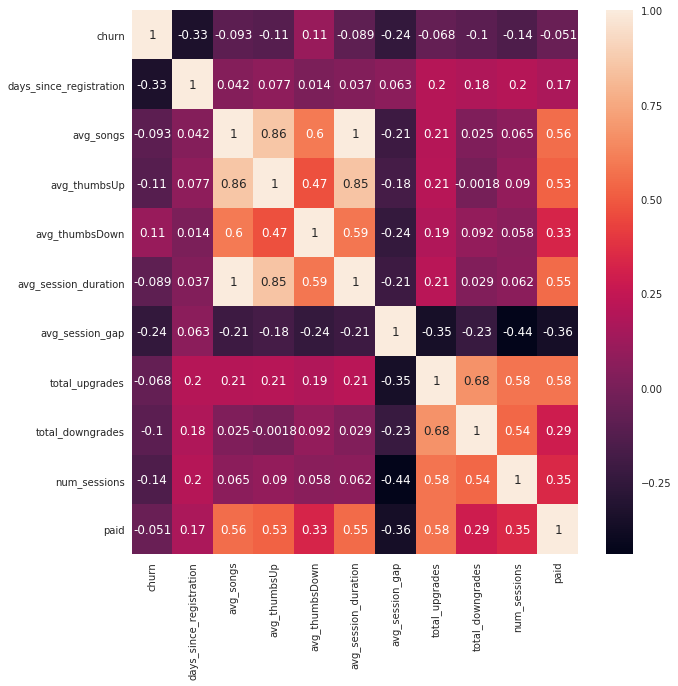

In [69]:
df_corr = ml_df.select("churn", "days_since_registration", "avg_songs", "avg_thumbsUp", "avg_thumbsDown", "avg_session_duration", 
                "avg_session_gap", "total_upgrades", "total_downgrades", "num_sessions", "paid").toPandas()
sns.set(rc={'figure.figsize':(10,10)},font_scale=1)

# plot correlation matrix
sns.heatmap(df_corr.corr(), annot=True)

There are no variables which produces similar results in the correlation analysis, therefore we will keep all of them.

In [70]:
numeric_cols = ["days_since_registration", "avg_songs", "avg_thumbsUp", "avg_thumbsDown", "avg_session_duration", 
                "avg_session_gap", "total_upgrades", "total_downgrades", "num_sessions", "paid"]

index_cols = ["gender", "level"]

new_ml_df = ml_df.select("days_since_registration", "avg_songs", "avg_thumbsUp", "avg_thumbsDown", "avg_session_duration", 
                         "avg_session_gap", "total_upgrades", "total_downgrades", "num_sessions", "paid", "gender", "level", "churn")
new_ml_df.head(3)

[Row(days_since_registration=55.64, avg_songs=39.29, avg_thumbsUp=2.43, avg_thumbsDown=0.71, avg_session_duration=2.57, avg_session_gap=173.87, total_upgrades=0, total_downgrades=0, num_sessions=7, paid=0, gender='F', level='free', churn=0),
 Row(days_since_registration=70.07, avg_songs=64.5, avg_thumbsUp=3.5, avg_thumbsDown=1.0, avg_session_duration=4.44, avg_session_gap=213.06, total_upgrades=1, total_downgrades=0, num_sessions=6, paid=1, gender='M', level='paid', churn=0),
 Row(days_since_registration=71.32, avg_songs=8.0, avg_thumbsUp=0.0, avg_thumbsDown=0.0, avg_session_duration=0.49, avg_session_gap=None, total_upgrades=0, total_downgrades=0, num_sessions=1, paid=0, gender='M', level='free', churn=1)]

In [71]:
# preparing dataset for predicting analysis
data = assemble_ml_data(numeric_cols, index_cols, new_ml_df)
data.head()

Row(days_since_registration=55.64, avg_songs=39.29, avg_thumbsUp=2.43, avg_thumbsDown=0.71, avg_session_duration=2.57, avg_session_gap=173.87, total_upgrades=0, total_downgrades=0, num_sessions=7, paid=0, gender='F', level='free', churn=0, gender_index=1.0, level_index=1.0, gender_index_ohe=SparseVector(2, {1: 1.0}), level_index_ohe=SparseVector(2, {1: 1.0}), vecfeatures=DenseVector([0.0, 1.0, 0.0, 1.0, 55.64, 39.29, 2.43, 0.71, 2.57, 173.87, 0.0, 0.0, 7.0, 0.0]))

Now the data is ready, let's feed to the same three machine learning algorithms, **Random Forest**, **Linear Regression** and **Linear SVC**.

In [75]:
# random forest
rf = RandomForestClassifier(labelCol="churn", featuresCol="features")

results = make_prediction(data, rf, paramGrid)

Py4JJavaError: An error occurred while calling o4020.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 3904.0 failed 1 times, most recent failure: Lost task 1.0 in stage 3904.0 (TID 125328, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$4: (struct<gender_index_ohe:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,level_index_ohe:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,days_since_registration:double,avg_songs:double,avg_thumbsUp:double,avg_thumbsDown:double,avg_session_duration:double,avg_session_gap:double,total_upgrades_double_VectorAssembler_86a3f6fbe3f8:double,total_downgrades_double_VectorAssembler_86a3f6fbe3f8:double,num_sessions_double_VectorAssembler_86a3f6fbe3f8:double,paid_double_VectorAssembler_86a3f6fbe3f8:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage15.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage15.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$15$$anon$2.hasNext(WholeStageCodegenExec.scala:655)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anonfun$1$$anon$1.hasNext(InMemoryRelation.scala:125)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "keep". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:287)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:255)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:35)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:255)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$4.apply(VectorAssembler.scala:144)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$4.apply(VectorAssembler.scala:143)
	... 44 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1098)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1092)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1161)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1137)
	at org.apache.spark.mllib.feature.StandardScaler.fit(StandardScaler.scala:57)
	at org.apache.spark.ml.feature.StandardScaler.fit(StandardScaler.scala:117)
	at org.apache.spark.ml.feature.StandardScaler.fit(StandardScaler.scala:87)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$4: (struct<gender_index_ohe:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,level_index_ohe:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,days_since_registration:double,avg_songs:double,avg_thumbsUp:double,avg_thumbsDown:double,avg_session_duration:double,avg_session_gap:double,total_upgrades_double_VectorAssembler_86a3f6fbe3f8:double,total_downgrades_double_VectorAssembler_86a3f6fbe3f8:double,num_sessions_double_VectorAssembler_86a3f6fbe3f8:double,paid_double_VectorAssembler_86a3f6fbe3f8:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage15.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage15.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$15$$anon$2.hasNext(WholeStageCodegenExec.scala:655)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anonfun$1$$anon$1.hasNext(InMemoryRelation.scala:125)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "keep". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:287)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:255)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:35)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:255)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$4.apply(VectorAssembler.scala:144)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$4.apply(VectorAssembler.scala:143)
	... 44 more


It appears that the dataset has some issues with the calcuulated columns. Let's check for nulls in these columns.

In [81]:
# empty dictionary with columns as keys and number of nulls as values
nulls = dict()

df_try = data.select("days_since_registration", "avg_songs", "avg_thumbsUp", "avg_thumbsDown", "avg_session_duration", 
                     "avg_session_gap", "total_upgrades", "total_downgrades", "gender", "level", "churn")

for c in df_try.columns:
    # count number of nulls
    a = df_try.filter(isnull(c)).count()
    nulls[c] = a
    

print('nulls: {}'.format(nulls))

nulls: {'days_since_registration': 0, 'avg_songs': 0, 'avg_thumbsUp': 0, 'avg_thumbsDown': 0, 'avg_session_duration': 0, 'avg_session_gap': 15, 'total_upgrades': 0, 'total_downgrades': 0, 'gender': 0, 'level': 0, 'churn': 0}


It seems that `avg_session_gap` has some nulls, let's check why.

In [82]:
# get users that have avg_session_gap null
nulls_avg_ses = np.array(df_user.select("userId").filter(isnull("avg_session_gap")).toPandas()['userId'])
nulls_avg_ses = list(nulls_avg_ses)
nulls_avg_ses              

['125',
 '133',
 '300007',
 '100006',
 '19',
 '300024',
 '135',
 '156',
 '100024',
 '100011',
 '300003',
 '100017',
 '63',
 '72',
 '151']

The list above is the list of users with `avg_session_gap` null. Let's see what happens with these users.

In [83]:
print(df.filter(df.userId=="125").groupBy("userId", "sessionId").agg({"page":"count"}).count(), 
df.filter(df.userId=="133").groupBy("userId", "sessionId").agg({"page":"count"}).count())

[Row(userId='125', sessionId=174, count(page)=11)]

The users with null `avg_session_gap` are those who have only one session registered. In order to avoid nulls for the variable, we will set it to 0 for those users with only one session registered.

In [72]:
# fill nulls with 0
df_user = df_user.na.fill(0)

# recompose the dataframe
ml_df = df_user.join(categorical_df, [df_user.userId == categorical_df.user])

numeric_cols = ["days_since_registration", "avg_songs", "avg_thumbsUp", "avg_thumbsDown", "avg_session_duration", 
                "avg_session_gap", "total_upgrades", "total_downgrades", "num_sessions", "paid"]
index_cols = ["gender", "level"]
new_ml_df = ml_df.select("days_since_registration", "avg_songs", "avg_thumbsUp", "avg_thumbsDown", "avg_session_duration", 
                         "avg_session_gap", "total_upgrades", "total_downgrades", "num_sessions", "paid", "gender", "level", "churn")

new_ml_df = new_ml_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK)

data = assemble_ml_data(numeric_cols, index_cols, new_ml_df)

In [73]:
data.head()

Row(days_since_registration=55.64, avg_songs=39.29, avg_thumbsUp=2.43, avg_thumbsDown=0.71, avg_session_duration=2.57, avg_session_gap=173.87, total_upgrades=0, total_downgrades=0, num_sessions=7, paid=0, gender='F', level='free', churn=0, gender_index=1.0, level_index=1.0, gender_index_ohe=SparseVector(2, {1: 1.0}), level_index_ohe=SparseVector(2, {1: 1.0}), vecfeatures=DenseVector([0.0, 1.0, 0.0, 1.0, 55.64, 39.29, 2.43, 0.71, 2.57, 173.87, 0.0, 0.0, 7.0, 0.0]))

Let's feed now the data to the ML models.

**Random Forest**

In [74]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

model, results = make_prediction(data, rf, paramGrid=None)

In [76]:
evaluation_metrics(results, "churn", "prediction")

             precision    recall  f1-score   support

          0       0.77      1.00      0.87        24
          1       1.00      0.30      0.46        10

avg / total       0.84      0.79      0.75        34



**Linear Regression**

In [77]:
lr = LogisticRegression(labelCol="label", featuresCol="features")

model, results = make_prediction(data, lr, paramGrid=None)

In [79]:
evaluation_metrics(results, "churn", "prediction")

             precision    recall  f1-score   support

          0       0.75      1.00      0.86        24
          1       1.00      0.20      0.33        10

avg / total       0.82      0.76      0.70        34



**Linear SVM**

In [80]:
LSVC = LinearSVC(labelCol="label", featuresCol="features")

model, results = make_prediction(data, LSVC, paramGrid=None)

In [82]:
evaluation_metrics(results, "churn", "prediction")

             precision    recall  f1-score   support

          0       0.77      1.00      0.87        24
          1       1.00      0.30      0.46        10

avg / total       0.84      0.79      0.75        34



Let's try with weight column and with parameter tuning.

In [83]:
data = data.withColumn("weight", label_weight(data.churn))

**Linear Regression**

In [84]:
lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="weight")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.05, 0.1, 0.5]) \
    .addGrid(lr.threshold,[0.3, 0.5, 0.8]) \
    .build()

model, results = make_prediction(data, lr, paramGrid=None)

f1 for Linear Regression with weight column and session:  0.8505718076704365


In [85]:
evaluation_metrics(results, "churn", "prediction")

             precision    recall  f1-score   support

          0       0.88      0.92      0.90        24
          1       0.78      0.70      0.74        10

avg / total       0.85      0.85      0.85        34



In [86]:
model.stages[-1].extractParamMap()

{Param(parent='LogisticRegression_e2fc425c8b16', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_e2fc425c8b16', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_e2fc425c8b16', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_e2fc425c8b16', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_e2fc425c8b16', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_e2fc425c8b16', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_e2fc425c8b16', name='maxIter', doc='maximum number of iterations (>= 0)'): 

**Linear SVM**

In [ ]:
LSVC = LinearSVC(labelCol="label", featuresCol="features", weightCol="weight")

# paramGrid = ParamGridBuilder() \
#     .addGrid(LSVC.maxIter, [5,10, 15]) \
#     .addGrid(LSVC.regParam, [0.0, 0.05, 0.1]) \
#     .build()

model, results = make_prediction(data, LSVC, paramGrid=None)
f1 = MulticlassClassificationEvaluator().evaluate(results.withColumnRenamed("churn", "label"))
print("f1 for Linear SVM with weight column and session: ", f1)

In [ ]:
evaluation_metrics(results, "churn", "prediction")

In [ ]:
model.stages[-1].extractParamMap()

The best results in terms of all metrics are given by Linear Regression, by considering label weights and also variables related to sessions, like `avg_session_gap`, as features, i.e. the second approach illustrated in this notebook.

# Putting All Together

Now that the whole process has been unpacked, from the preliminary data analysis to the model setup and tuning, let's put everything together.

In [7]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Churn Prediction") \
    .getOrCreate()

# read in the data
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

# filter out rows with no user id
df = df.filter(df.userId != "")

In [8]:
# mark as churn those records with Cancellation Confirmation
make_churn = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", make_churn(df.page))

In [18]:
# get lists of churn and not churn users, churn users have churn=1, whereas not churn users have churn=0
churn_users = np.array(df.select("userId").filter(df.churn==1).dropDuplicates().toPandas()["userId"])
users = np.array(df.select("userId").filter(df.churn==0).dropDuplicates().toPandas()["userId"])
not_churn_users = np.setdiff1d(users, churn_users)

not_churn_users = list(not_churn_users)
churn_users = list(churn_users)
n_churn_users = len(churn_users)
n_not_churn_users = len(not_churn_users)

In [21]:
# define function to preprocess data
def preprocess_data(df):

    lookup = df.groupby("userId").agg({"ts":"max"}).withColumnRenamed("MAX(ts)", "time").withColumnRenamed("userId", "user")
    categorical_df = df.join(lookup, [df.ts == lookup.time, df.userId == lookup.user])

    # calculate the difference in timestamp of each record from the registration timestamp
    categorical_df = categorical_df.withColumn("rgstr_time", col("ts") - col("registration"))

    # define a user funtion that transforms timestamp in days
    diff_days = udf(lambda x: round(x/1000.0/3600.0/24.0, 2), DoubleType())

    # calculate the new column
    categorical_df = categorical_df.withColumn("days_since_registration", diff_days(categorical_df.rgstr_time))
    categorical_df = categorical_df.select("gender", "location", "level", "userAgent", "user", # select only relevant columns
                                       "days_since_registration").dropDuplicates()

    # the user defined functions are the same as above
    is_thumbs_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
    is_thumbs_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
    has_upgraded = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
    has_downgraded = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
    is_song = udf(lambda x: 1 if x is not None else 0, IntegerType())
    has_been_paid = udf(lambda x:1 if x == "paid" else 0, IntegerType())

    df_ses = df.withColumn("thumbsUp", is_thumbs_up(df.page))\
        .withColumn("thumbsDown", is_thumbs_down(df.page))\
        .withColumn("upgraded", has_upgraded(df.page))\
        .withColumn("downgraded", has_downgraded(df.page))\
        .withColumn("songCheck", is_song(df.song))\
        .withColumn("paid", has_been_paid(df.level))

    df_ses = df_ses.select("userId", "sessionId", "churn", "ts", "thumbsUp", "thumbsDown",
                  "upgraded", "downgraded", "songCheck", "paid") # no use of song length because of correlation seen before

    # the group by is now done both at the user and session level
    df_user_ses = df_ses.groupby("userId", "sessionId").agg(max("churn").alias("churn"),\
                                          min("ts").alias("ses_start"),\
                                          max("ts").alias("ses_end"),\
                                          Fsum("thumbsUp").alias("thumbsUp"),\
                                          Fsum("thumbsDown").alias("thumbsDown"),\
                                          Fsum("upgraded").alias("upgraded"),\
                                          Fsum("downgraded").alias("downgraded"),\
                                          Fsum("songCheck").alias("num_songs"),\
                                          max("paid").alias("paid"))

    df_user_ses = df_user_ses.withColumn("sessionDuration_hours", (col("ses_end") - col("ses_start"))/1000.0/3600.0)

    # create window function
    user_window = Window \
       .partitionBy("userID") \
       .orderBy(asc("ses_start"))

    # get the timestamp at the end of the previous session
    df_user_ses = df_user_ses.withColumn("prev_ses_end", lag(col("ses_end")).over(user_window))
    # calculate session gap as the difference between the start date of the current session and the end date of the previous one
    df_user_ses = df_user_ses.withColumn("sessiongap_hours", (col("ses_start") - col("prev_ses_end"))/1000.0/3600.0)

    # summarize all the features as average per session
    df_user = df_user_ses.groupby("userId").agg(max("churn").alias("churn"),\
                                   count("sessionId").alias("num_sessions"),\
                                   Fround(avg("thumbsUp"),2).alias("avg_thumbsUp"),\
                                   Fround(avg("thumbsDown"),2).alias("avg_thumbsDown"),\
                                   Fsum("upgraded").alias("total_upgrades"),\
                                   Fsum("downgraded").alias("total_downgrades"),\
                                   Fround(avg("num_songs"),2).alias("avg_songs"),\
                                   Fround(avg("sessionDuration_hours"),2).alias("avg_session_duration"),\
                                   Fround(avg("sessiongap_hours"),2).alias("avg_session_gap"),\
                                   max("paid").alias("paid"))

    ml_df = df_user.join(categorical_df, [df_user.userId == categorical_df.user])
    ml_df = ml_df.na.fill(0)

    new_ml_df = ml_df.select("days_since_registration", "avg_songs", "avg_thumbsUp", "avg_thumbsDown", "avg_session_duration", 
                         "avg_session_gap", "total_upgrades", "total_downgrades", "num_sessions", "paid", "gender", "level", "churn")

    new_ml_df = new_ml_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    return new_ml_df

In [22]:
new_ml_df = preprocess_data(df)

In [23]:
numeric_cols = ["days_since_registration", "avg_songs", "avg_thumbsUp", "avg_thumbsDown", "avg_session_duration", 
                "avg_session_gap", "total_upgrades", "total_downgrades", "num_sessions", "paid"]
index_cols = ["gender", "level"]

data = assemble_ml_data(numeric_cols, index_cols, new_ml_df)

# let's calculate weights for churn and not churn users
churn_weight = n_not_churn_users/(n_churn_users + n_not_churn_users)
not_churn_weight = n_churn_users/(n_churn_users + n_not_churn_users)

# get weight column for the dataframe
label_weight = udf(lambda x: churn_weight if x==1 else not_churn_weight, DoubleType())

data = data.withColumn("weight", label_weight(data.churn))

In [24]:
lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="weight", regParam=0.0, threshold=0.5)

model, results = make_prediction(data, lr, paramGrid=None)

In [25]:
evaluation_metrics(results, "churn", "prediction")

Accuracy:  0.8529411764705882
             precision    recall  f1-score   support

          0       0.88      0.92      0.90        24
          1       0.78      0.70      0.74        10

avg / total       0.85      0.85      0.85        34



|model|accuracy|precision|recall|f1 score|
|---|---|---|---|---|
|LR|0.85|0.85|0.85|0.85|